Written by Jorge: 20240429

Copied from 1g_EEGNET..

On this notebook I will try to train modelsf based on DeepConVNet, also available from the EEGNet library



# **1. Instancies and libraries**

## 1.1 Install MNE to visualize and, potentially, process EEG data

In [ ]:
pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.9 MB/s eta 0:00:00


## 1.2 Add EEGNet library to the environmental variable

In [ ]:
import sys
path = "/content/EEGNet"
sys.path.append(path)

## 1.3 **Import** the main libraries. This ones will be used across all the program

In [ ]:
# Filesystem
import os
import zipfile

# data processing
import numpy as np
import pandas as pd

# AI-related
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
import itertools

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# MNE
import mne
from mne import io

#EEGNET
from EEGModels import DeepConvNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


# **2. Functions**

## 2.1 Function to visualize the performance of the model

In [ ]:
def visualize_results (model, n_epochs):
  epochs = [i for i in range (n_epochs)]
  fig, ax = plt.subplots(1,2)
  train_acc = model.history["accuracy"]
  train_loss = model.history["loss"]
  val_acc = model.history["val_accuracy"]
  val_loss = model.history["val_loss"]
  fig.set_size_inches(16,9)

  ax[0].plot(epochs, train_acc, "go-", label = "Training Accuracy")
  ax[0].plot(epochs, val_acc, "ro-", label = "Validation Accuracy")
  ax[0].set_title("Training and Validation Accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-", label = "Training Loss")
  ax[1].plot(epochs, val_loss, "ro-", label = "Validation Loss")
  ax[1].set_title("Training and Validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

## 2.2 **Function** to plot Confusion Matrix

In [ ]:
def plot_confusion_matrix (cm,
                           classes,
                           normalize = False,
                           title = 'Confusion Matrix',
                           cmap=plt.cm.Greens
                          ):
  plt.imshow (cm, interpolation='nearest', cmap=cmap)
  plt.title (title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(cm)

  thresh = cm.max()*0.80
  for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, round(cm[i,j],2),
              horizontalalignment="center",
              color="white" if cm [i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

## 2.3 Function to normalize EEG data (run inside the loop to assemble the tensor)

In [ ]:
def normalize_channels (data, n_channels):
  data_norm = np.zeros_like(data, dtype='float32')
  for ch in range (n_channels):
      min_val = (np.min(data[ch]))
      max_val = (np.max(data[ch]))
      data_norm [ch] = (data[ch] - min_val) / (max_val - min_val)

  return data_norm

# **3. Data Load**

## 3.1 Unzip dataset

In [ ]:
local_zip = "/content/ERP_Pretest_Data_128Hz.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/ERP_Pretest_Data_128_Hz")
zip_ref.close()

## 3.2 Define file paths

In [ ]:
train_data_path = "/content/ERP_Pretest_Data_128_Hz/Train/"
test_data_path = "/content/ERP_Pretest_Data_128_Hz/Test/"

## 3.3 Load file lists

In [ ]:
trainlist = open  ("/content/ERP_Pretest_Data_128_Hz/TrainFileList.txt", "r")
data = trainlist.read()
train_data_all_files = data.split("\n")

testlist = open  ("/content/ERP_Pretest_Data_128_Hz/TestFileList.txt", "r")
data_ = testlist.read()
test_data_all_files = data_.split("\n")

## 3.4 Determine the number of trials available based on the number of files

In [ ]:
n_trials_train = len(train_data_all_files)
n_trials_test = len(test_data_all_files)

## 3.5 Define the parameters for EEG data

In [ ]:
n_channels = 20
n_samples = 128
n_kernels = 1

ch_names = ['Fz', 'F7', 'F3', 'F4', 'F8',
            'T7', 'C3', 'CZ', 'C4', 'T8',
            'P7', 'P3', 'Pz', 'P4', 'P8',
            'O1', 'Oz', 'O2', 'LM', 'RM']

sfreq = 128
info = mne.create_info(ch_names = ch_names, sfreq = sfreq)

## 3.6 Load training data

This data will be loaded as 2D array for augmentation and balancing

In [ ]:
train_set_2D = np.zeros ((n_trials_train,n_channels*n_samples), dtype='float32')

In [ ]:
trial = 0
for filename in train_data_all_files:
  data = pd.read_csv(filename, header=None, dtype=np.float32)
  trl = np.reshape (np.array(data), (n_channels*n_samples))
  train_set_2D[trial:] = trl
  trial=trial+1

Load labels for training data

In [ ]:
train_labels_path = '/content/ERP_Pretest_Data_128_Hz/TrainLabels.csv'
train_labels = np.array(pd.read_csv(train_labels_path, header=None, dtype='uint8'))
train_labels = np.squeeze(train_labels.T)

Balance the training set using the Random Oversampler

In [ ]:
oversampler_train = RandomOverSampler(sampling_strategy='minority')
traindata_over, trainlabels_over = oversampler_train.fit_resample(train_set_2D, train_labels)
(overTrials_tr, overSamples_tr) = traindata_over.shape

Allocate data in tensor

In [ ]:
X_train = np.zeros((overTrials_tr,n_channels,n_samples), dtype=np.float32)

In [ ]:
for i in range(overTrials_tr):
  trl_rs = np.reshape (traindata_over[i],(n_channels,n_samples))
  # Optional operation to check if this improves the model performance
  trl_rs = normalize_channels(np.array(trl_rs, dtype='float32'), n_channels)
  X_train[i] = trl_rs

# reasign the training labels
y_train = trainlabels_over
print(y_train.shape)

(1342,)


Visualize the first trial in the set

Creating RawArray with float64 data, n_channels=20, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.992 secs
Ready.


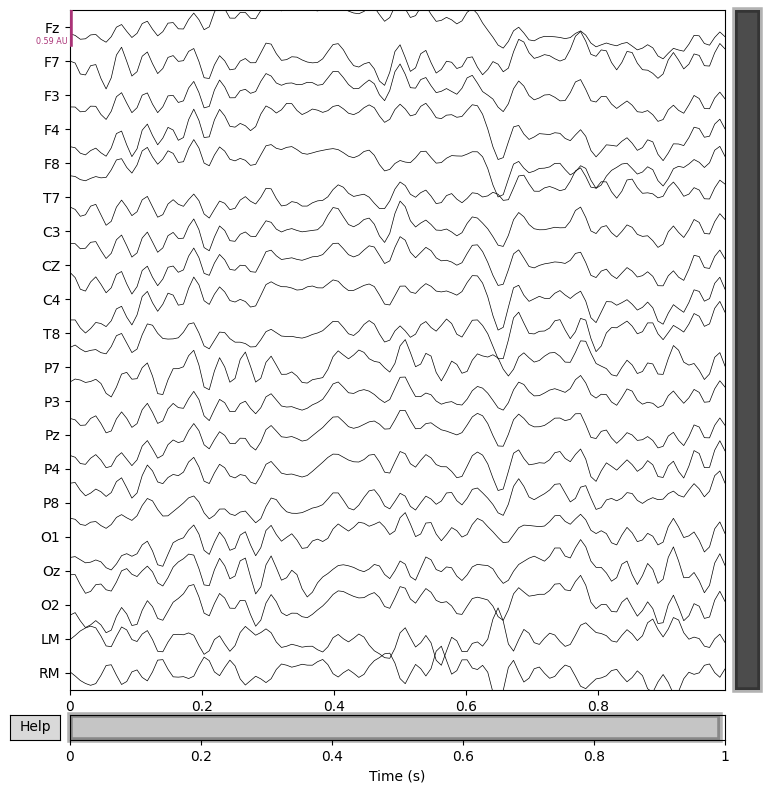

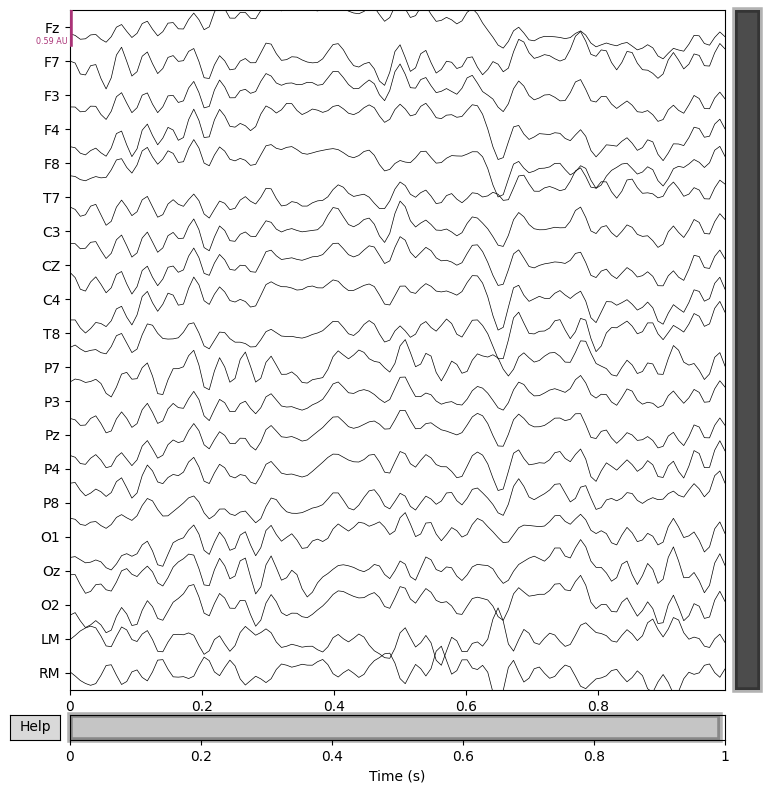

In [ ]:
example = mne.io.RawArray(X_train[0], info)
example.plot(block=True)

## 3.7 Load test data

This is a similar process to loading the training data, we perform oversampling here too

In [ ]:
test_set_2D = np.zeros ((n_trials_test,n_channels*n_samples), dtype='float32')

In [ ]:
trial = 0
for filename in test_data_all_files:
  data = pd.read_csv(filename, header=None, dtype=np.float32)
  trl = np.reshape (np.array(data), (n_channels*n_samples))
  test_set_2D[trial:] = trl
  trial=trial+1

Load test data labels

In [ ]:
test_labels_path = '/content/ERP_Pretest_Data_128_Hz/TestLabels.csv'
test_labels = np.array(pd.read_csv(test_labels_path, header=None, dtype='uint8'))
test_labels = np.squeeze(test_labels.T)

Balance with Random Oversampler

In [ ]:
oversampler_test = RandomOverSampler(sampling_strategy='minority')
testdata_over, testlabel_over = oversampler_test.fit_resample(test_set_2D, test_labels)
(overTrials_ts,overSamples_ts) = testdata_over.shape

Allocate in tensor

In [ ]:
X_test = np.zeros((overTrials_ts,n_channels,n_samples), dtype=np.float32)

In [ ]:
for i in range(overTrials_ts):
  trl_rs = np.reshape (testdata_over[i],(n_channels,n_samples))
  # Optional operation to check if this improves the model performance
  trl_rs = normalize_channels(np.array(trl_rs, dtype='float32'), n_channels)
  X_test[i] = trl_rs

# reasign the training labels
y_test = testlabel_over
print(y_test.shape)

(350,)


Visualize example

Creating RawArray with float64 data, n_channels=20, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.992 secs
Ready.


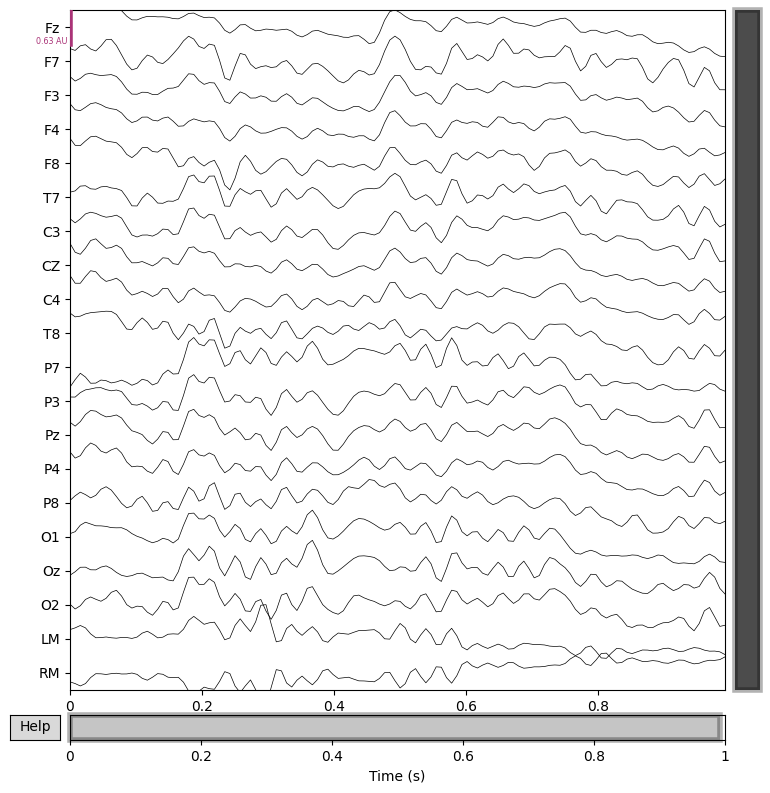

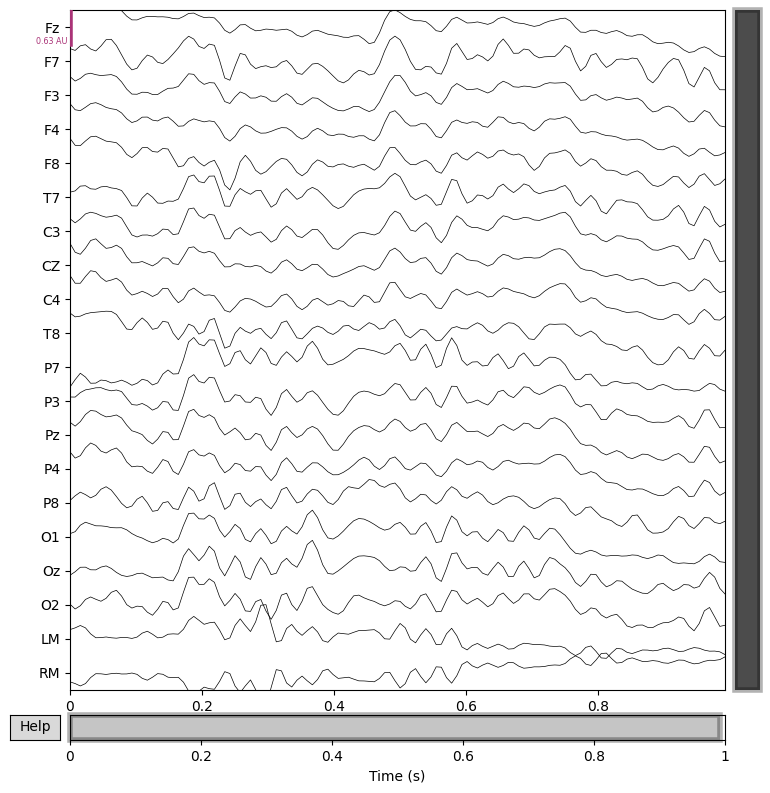

In [ ]:
test_example = mne.io.RawArray(X_test[0], info)
test_example.plot(block=True)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1342, 20, 128)
(350, 20, 128)


# **4. DeepConvNet Portion**

## 4.1 Define model architecture

Parameters for model training, let's start with the defaults

In [ ]:
# Model Build
classes = 2
dropout_rate = 0.2                  # hp.Float  ('dropoutRate',  min_value=0.2, max_value=0.5, sampling="log")
# kernel_length = 64                  # hp.Choice ('kernLength', values = [16, 32, 64])
# f1 = 8                              # hp.Choice ('F1', values = [4, 8])
# d = 2                               # hp.Choice ('D', values = [1, 2])
# f2 = f1*d
# #dropout_type = 'SpatialDropout2D'   # hp.Choice ('dropoutType', values = ['Dropout', 'SpatialDropout'])

# Compile
lr = 1e-4                           # hp.Float  ('learning_rate',  min_value=1e-6, max_value=1e-2, sampling="log")

batch = 16
epoch = 300

Create the EEGNet model with the parameters above

In [ ]:
DeepConvNet_Model0 = DeepConvNet(nb_classes = classes,
                       Chans = n_channels,
                       Samples = n_samples,
                       dropoutRate = dropout_rate)

DeepConvNet_Model0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 128, 1)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 124, 25)       150       
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 124, 25)        12525     
                                                                 
 batch_normalization_4 (Bat  (None, 1, 124, 25)        100       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 1, 124, 25)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 62, 25)         0         
 g2D)                                                      

Let's save the architecture to use it in other models

In [ ]:
DeepConvNet_Template = DeepConvNet_Model0.get_config ()


 ****

****UP TO THIS POINT EVERYTHING IS FIXED, FROM HERE ON WE START TO ITERATE****

***


## 4.2 Generate validation data

First we generate an array containing all the possible indeces in the training set. From this, we are going to select 350 random values making sure they will not be repeated

In [ ]:
train_indeces = np.arange(0,overTrials_tr)
n_trials_val = overTrials_ts
val_indeces = np.random.choice(train_indeces, n_trials_val, replace=False)

In [ ]:
val_indeces.sort()
print (val_indeces)

[   2    5   10   11   17   20   21   25   27   29   30   36   37   43
   48   49   50   53   55   57   60   62   67   77   82   86   88   90
  109  111  120  122  124  133  139  141  148  150  151  157  159  163
  164  168  174  182  184  185  189  194  199  203  205  209  213  214
  217  220  226  234  236  238  244  246  248  250  254  256  258  264
  269  277  280  284  285  290  299  307  312  313  314  316  317  327
  331  336  337  338  340  345  347  349  351  357  362  365  374  390
  391  392  393  394  395  406  408  420  424  425  426  428  430  436
  439  444  452  453  457  459  462  464  468  473  474  475  478  480
  483  484  487  492  493  494  506  509  512  516  521  523  528  530
  536  538  539  542  543  556  564  572  574  581  585  593  594  595
  596  598  602  603  607  608  610  613  617  620  622  623  642  647
  649  652  658  661  663  666  668  672  674  675  679  694  697  704
  712  718  727  729  730  732  737  738  744  751  759  762  767  768
  776 

We create a container for the testing data

In [ ]:
X_val = np.zeros((n_trials_val,n_channels,n_samples), dtype=np.float32)
y_val =np.zeros (n_trials_val, dtype=np.uint8)
selected_trials = list(val_indeces)

We start populating the validation subset the same way as before. This time we will use the data contained in training subset. Also, generate the labels for this subset in the same loop

In [ ]:
trial = 0
for i in selected_trials:
  X_val[trial::] = X_train[i]
  y_val[trial] = y_train[i]
  trial = trial+1

In [ ]:
print (X_val.shape)
print (y_val.shape)

(350, 20, 128)
(350,)


Create a new training set by removing the selected trials for validation from the original

In [ ]:
X_train_new = np.delete (X_train, val_indeces, axis=0)
y_train_new = np.delete (y_train, val_indeces)

In [ ]:
print (X_train_new.shape)
print (y_train_new.shape)

(992, 20, 128)
(992,)


## 4.3 Reshape data and labels to one-hot encodings

In [ ]:
X_train_new = X_train_new.reshape(X_train_new.shape[0], n_channels, n_samples, n_kernels)
X_val_rs       = X_val.reshape(X_val.shape[0], n_channels, n_samples, n_kernels)
X_test_rs      = X_test.reshape(X_test.shape[0], n_channels, n_samples, n_kernels)

print(X_train_new.shape)
print(X_val_rs.shape)
print(X_test_rs.shape)

(992, 20, 128, 1)
(350, 20, 128, 1)
(350, 20, 128, 1)


In [ ]:
y_train_new = np_utils.to_categorical(y_train_new)
print(y_train_new.shape)

y_val_rs = np_utils.to_categorical(y_val)
print (y_val_rs.shape)

y_test_model = np_utils.to_categorical(y_test)
print (y_test_model.shape)

(992, 2)
(350, 2)
(350, 2)


Training block

Generate model with the template

In [ ]:
DeepConvNet_Model1 = tf.keras.Sequential.from_config(DeepConvNet_Template)
DeepConvNet_Model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 20, 124, 25)       150       
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 124, 25)        12525     
                                                                 
 batch_normalization_4 (Bat  (None, 1, 124, 25)        100       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 1, 124, 25)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 62, 25)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1, 62, 25)         0   

Compile model

In [ ]:
import keras
from keras import optimizers

opt = keras.optimizers.Adam(learning_rate = lr)

DeepConvNet_Model1.compile(loss='binary_crossentropy',
               optimizer=opt,
               metrics = ['accuracy'])


Callback Block

In [ ]:
#Checkpointer
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint2.h5',
                               verbose=1,
                               save_best_only=True)

Train model

In [ ]:
fittedModel1 = DeepConvNet_Model1.fit(X_train_new,
                                 y_train_new,
                                 batch_size = batch,
                                 epochs = epoch,
                                 verbose = 2,
                                 validation_data=(X_val_rs, y_val_rs),
                                 callbacks=[checkpointer])

# load optimal weights
DeepConvNet_Model1.load_weights('/tmp/checkpoint2.h5')

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.68306, saving model to /tmp/checkpoint2.h5
62/62 - 5s - loss: 0.7163 - accuracy: 0.5192 - val_loss: 0.6831 - val_accuracy: 0.5857 - 5s/epoch - 80ms/step
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.68306 to 0.67359, saving model to /tmp/checkpoint2.h5
62/62 - 0s - loss: 0.6758 - accuracy: 0.6048 - val_loss: 0.6736 - val_accuracy: 0.5571 - 484ms/epoch - 8ms/step
Epoch 3/300

Epoch 3: val_loss improved from 0.67359 to 0.66745, saving model to /tmp/checkpoint2.h5
62/62 - 1s - loss: 0.6679 - accuracy: 0.5968 - val_loss: 0.6675 - val_accuracy: 0.5771 - 511ms/epoch - 8ms/step
Epoch 4/300

Epoch 4: val_loss improved from 0.66745 to 0.65769, saving model to /tmp/checkpoint2.h5
62/62 - 0s - loss: 0.6506 - accuracy: 0.6472 - val_loss: 0.6577 - val_accuracy: 0.6114 - 477ms/epoch - 8ms/step
Epoch 5/300

Epoch 5: val_loss improved from 0.65769 to 0.65491, saving model to /tmp/checkpoint2.h5
62/62 - 1s - loss: 0.6350 - accuracy: 0.6583 - val_loss: 0.6549 - val_accuracy: 0.6086 - 501ms/epoch - 8ms/step
Epoch 6/300

Epoch 6: val_loss improved from 0.65491 to 0.64561, saving model to /tmp/checkpoint2.h5
62/62 - 0s - loss: 0.6167 - accuracy: 0.6653 - val_loss: 0.

Evaluate model

In [ ]:
probs       = DeepConvNet_Model1.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == y_test_model.argmax(axis=-1))
print("Classification accuracy: %.2f " % (acc))

11/11 [==============================] - 0s 2ms/step
Classification accuracy: 0.55 


Learning and loss plots

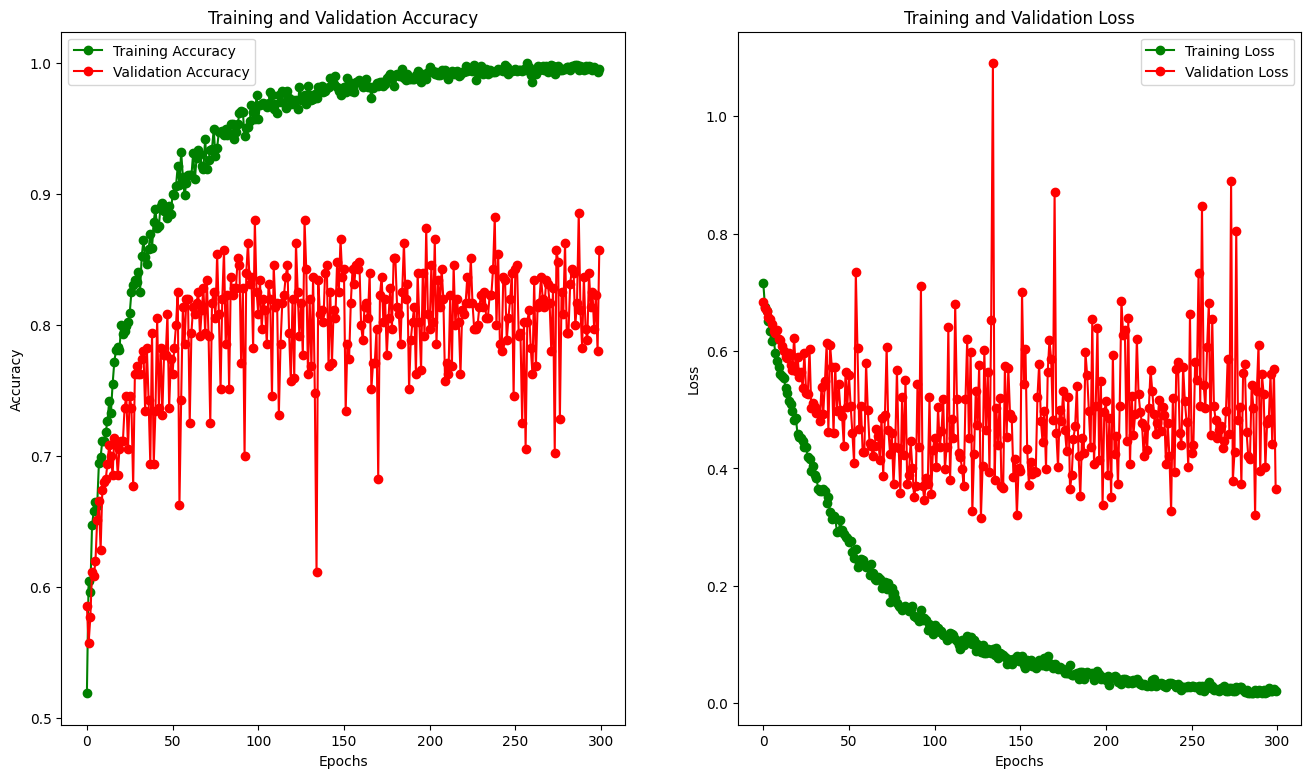

In [ ]:
visualize_results (fittedModel1, epoch)

Confusion Matrix

Confusion matrix, without normalization
[[138  37]
 [121  54]]


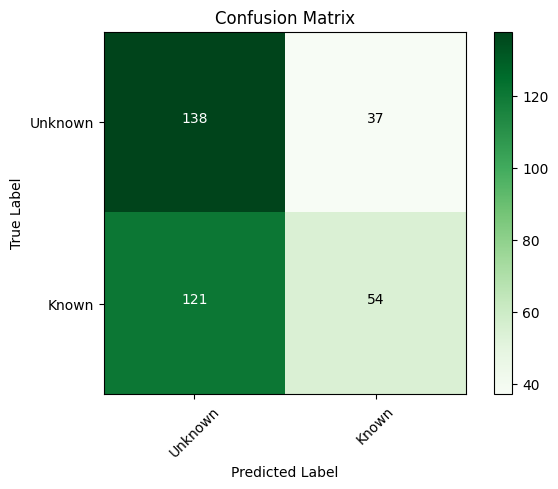

In [ ]:
cm = confusion_matrix((y_test), preds)
cm_plot_labels = ['Unknown', 'Known']
plot_confusion_matrix(cm, cm_plot_labels, normalize=False, title='Confusion Matrix')

Normalized confusion matrix
[[0.78857143 0.21142857]
 [0.69142857 0.30857143]]


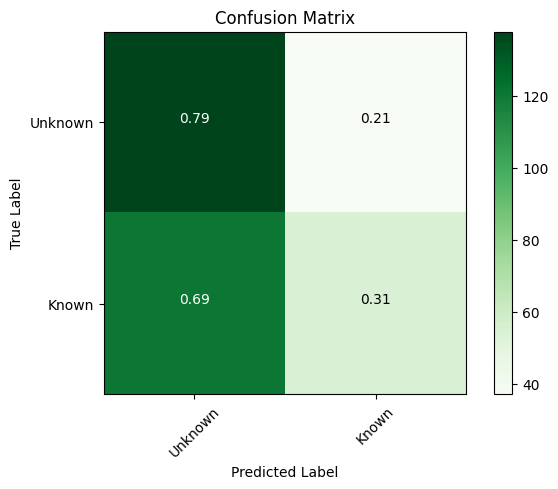

In [ ]:
cm = confusion_matrix((y_test), preds)
cm_plot_labels = ['Unknown', 'Known']
plot_confusion_matrix(cm, cm_plot_labels, normalize=True, title='Confusion Matrix')

Save Model

In [ ]:
DeepConvNet_Model1.save_weights('/content/output/DeepConvNet_Model1.h5')

Save predictions and test labels

In [ ]:
import pandas as pd
outputfile = '/content/output/DeepConvNet_Model.csv'
df = pd.DataFrame({'Test_Labels': y_test, 'Predictions': preds})
df.to_csv(outputfile)
